### Modul import

In [1]:
# Common
import pandas as pd
import numpy as np

# Text processing
import re
from bs4 import BeautifulSoup
import nltk

# Visualization modules
import matplotlib.pyplot as plt

# Model modules
from sklearn.feature_extraction.text import TfidfVectorizer#, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.test.utils import get_tmpfile
from gensim.test.utils import datapath
from gensim.models.ldamulticore import LdaMulticore

from gensim.models import phrases, word2vec

# Remove unnecessary warnings
pd.options.mode.chained_assignment = None


C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load Functions

In [2]:
from lipht_lda import df_lda_preprocessing, lda_preprocess_string, df_lda_features, get_lda_topics, lda_predict_df, lda_predict_string, document_to_bow

# Import Data

In [ ]:
df_raw = pd.read_pickle('data/AKA_rawdata.pkl')
df_import = df_raw.copy(deep=True)

In [3]:
# df_import = pd.read_pickle('data/AKA_rawdata_df_lda_preprocessed.pkl')
df_import = pd.read_pickle('data/AKA_rawdata_with_language.pkl')

#### Setup Analysis Parameters

In [4]:
dataset = 'df_B'
n_gram = 2
sample_size= 10000
no_words= 5000
no_below= 20 # filter out tokens that appear in less than 15 documents
random_state=1
research_scope = 'Udbetaling'
num_topics = 20

In [5]:
# Create dataset for method B
# Process 1st MemberMessage, then
# Concatenate with Subject
df_B = df_import.copy(deep=True)
df_B.head()

,ThreadID,ThreadCreatedFromLetter,ThreadTotalMessageCount,ThreadStatus,ThreadSubject,ThreadResponsibleDepartment,ThreadResponsibleDepartmentTeam,ThreadHasInteraction,ThreadInitiatedBy,ThreadMessageRank,...,text_Exclamationmarks,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,prediction,pred_probability,pred_index,pred_label
0,3F206D77-DFB5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,...,0,"[din, booking, er, på, plads, vi, bekræfter, a...","[booking, plads, bekræfter, tilmeldt, studieku...","[booking, plads, bekræfter, tilmeldt, studieku...","[book, plad, bekræfter, tilmeldt, studiekursu,...","[(43, 1), (46, 1), (104, 1), (142, 1), (146, 2...","[0.9617956, 0, Danish]",0.961796,0,Danish
1,A4B4F902-E4B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,...,0,"[din, booking, er, på, plads, vi, bekræfter, a...","[booking, plads, bekræfter, tilmeldt, talent, ...","[booking, plads, bekræfter, tilmeldt, talent, ...","[book, plad, bekræfter, tilmeldt, talent, tilr...","[(43, 1), (46, 1), (142, 1), (148, 1), (149, 1...","[0.95124453, 0, Danish]",0.951245,0,Danish
2,C7AAAE22-E4B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,...,0,"[din, booking, er, på, plads, vi, bekræfter, a...","[booking, plads, bekræfter, tilmeldt, talent, ...","[booking, plads, bekræfter, tilmeldt, talent, ...","[book, plad, bekræfter, tilmeldt, talent, tilr...","[(43, 1), (46, 1), (142, 1), (148, 1), (149, 1...","[0.9569702, 0, Danish]",0.956970,0,Danish
3,447AC33F-E6B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er nu afmeldt ventelisten til LinkedIn,Jobmatch,Logistik,0,AKA,1,...,0,"[du, er, nu, afmeldt, ventelisten, til, linked...","[afmeldt, ventelisten, linkedin, blevet, tilbu...","[afmeldt, ventelisten, linkedin, blevet, tilbu...","[afmeldt, ventelisten, linkedin, blevet, tilbu...","[(8, 1), (13, 1), (36, 1), (43, 1), (149, 1), ...","[0.9625676, 0, Danish]",0.962568,0,Danish
4,80A4A5A3-EAB5-E811-82B4-0050569118B0,0,1,Fuldført,Du er nu på venteliste til Mindfulness,Jobmatch,Logistik,0,AKA,1,...,0,"[salvador, rodriguez, du, er, nu, på, ventelis...","[salvador, rodriguez, ventelisten, mindfulness...","[salvador, rodriguez, ventelisten, mindfulness...","[salvador, rodriguez, ventelisten, mind, septe...","[(11, 1), (43, 1), (62, 1), (146, 1), (149, 1)]","[0.93669635, 0, Danish]",0.936696,0,Danish


In [6]:
df_B.shape

(1101095, 31)

In [7]:
%%time
# df_B = df_B[(df_B['ThreadStatus']=='Fuldført') & (df_B['ThreadMessageDirection']=='Indgående') & (df_B['ThreadMessageIsFirstMemberMessage']==1) & (df_B['ThreadTotalMessageCount']>1) & (df_B['ThreadHasInteraction']>=1) & (df_B['ThreadResponsibleDepartmentTeam']=='Udbetalingsteam') & (df_B['pred_label']=='Danish')]
df_B = df_B[(df_B['ThreadStatus']=='Fuldført') & (df_B['ThreadMessageDirection']=='Indgående') & (df_B['ThreadMessageIsFirstMemberMessage']==1) & (df_B['ThreadResponsibleDepartmentTeam'].str.contains('Udbetalingsteam')==True) & (df_B['pred_label']=='Danish')]
print(df_B.shape)

(87757, 31)
Wall time: 1.53 s


In [ ]:
df_B.ThreadResponsibleDepartmentTeam.unique()

In [8]:
%%time
df_lda_preprocessing(df_B,'ThreadMessageText',n_gram)

Wall time: 5min 22s


In [9]:
df_B.isnull().sum()

ThreadID                              0
ThreadCreatedFromLetter               0
ThreadTotalMessageCount               0
ThreadStatus                          0
ThreadSubject                        12
ThreadResponsibleDepartment           0
ThreadResponsibleDepartmentTeam       0
ThreadHasInteraction                  0
ThreadInitiatedBy                     0
ThreadMessageRank                     0
ThreadMessageIsFirstMemberMessage     0
ThreadMessageIsFirstAKAMessage        0
ThreadMessageID                       0
ThreadMessageDirection                0
ThreadMessageDateCreated              0
ThreadMessageText                     0
text                                  0
text_CharCount                        0
text_LessThan5000                     0
text_Questionmarks                    0
text_1Question                        0
text_Exclamationmarks                 0
tokenized_text                        0
stopwords_removed                     0
lemmatized_text                       0


In [10]:
print(df_B.shape)

(87757, 32)


In [11]:
df_B.to_pickle('data/df_B.pkl')

## Analyze Requests
Messages are either
- Incoming (from members) or
- Outgoing (from aka)
All messeages have
- subject_field and
- message_field

In the following we will analyze the different splits of data, with regards to the above:
- Incoming_subject
- Incoming_message
- Outgoing_subject
- Outgoing_message

### Request Analysis: subject_member

#### Load the data

In [12]:
%%time
# Load the data, and print rows, columns
df_scope = pd.read_pickle('data/{}.pkl'.format(dataset))

Wall time: 13.5 s


In [13]:
df_scope.shape

(87757, 32)

In [14]:
data_scope_name = research_scope +'_topics-'+ str(num_topics) +'_Sample-'+str(sample_size) +'_WordCount-'+str(no_words) +'_RandomState-'+str(random_state)+'_dataset-'+ dataset
print(data_scope_name)

Udbetaling_topics-20_Sample-10000_WordCount-5000_RandomState-1_dataset-df_B


### Vectorize words

#### Create dictionary and top words

##### Parameters:	
- **no_below** (int, optional) – Keep tokens which are contained in at least no_below documents.
- **no_above** (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
- **keep_n** (int, optional) – Keep only the first keep_n most frequent tokens.
- **keep_tokens** (iterable of str) – Iterable of tokens that must stay in dictionary after filtering.

In [15]:
%%time
# Create dictionary with words from df_scope (the total dataset)
dictionary = Dictionary(documents=df_scope.stemmed_text.values)
print("Found {} words.".format(len(dictionary.values())))

Found 579249 words.
Wall time: 15.1 s


In [16]:
%%time
# dictionary.filter_extremes(no_above=0.8, no_below=3)
dictionary.filter_extremes(no_below=no_below, keep_n=no_words)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 5000 words.
Wall time: 1.97 s


In [ ]:
def document_to_bow(df, dictionary):
    "Make a BoW for every Besked"
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))

In [17]:
%%time
#Make a BoW for every Besked
document_to_bow(df_scope, dictionary)

Wall time: 6.9 s


#### Create Sample of Scope

In [18]:
scope_lda_sample = df_scope.sample(sample_size, random_state=random_state)
scope_lda_sample.shape

(10000, 32)

In [19]:
scope_lda_sample.columns.values

array(['ThreadID', 'ThreadCreatedFromLetter', 'ThreadTotalMessageCount',
       'ThreadStatus', 'ThreadSubject', 'ThreadResponsibleDepartment',
       'ThreadResponsibleDepartmentTeam', 'ThreadHasInteraction',
       'ThreadInitiatedBy', 'ThreadMessageRank',
       'ThreadMessageIsFirstMemberMessage',
       'ThreadMessageIsFirstAKAMessage', 'ThreadMessageID',
       'ThreadMessageDirection', 'ThreadMessageDateCreated',
       'ThreadMessageText', 'text', 'text_CharCount', 'text_LessThan5000',
       'text_Questionmarks', 'text_1Question', 'text_Exclamationmarks',
       'tokenized_text', 'stopwords_removed', 'lemmatized_text',
       'stemmed_text', 'bow', 'prediction', 'pred_probability',
       'pred_index', 'pred_label', 'text_WordCount'], dtype=object)

In [20]:
scope_lda_sample[['ThreadID','ThreadMessageID','ThreadSubject','ThreadMessageText','text','tokenized_text','stopwords_removed','lemmatized_text','stemmed_text']].head()

,ThreadID,ThreadMessageID,ThreadSubject,ThreadMessageText,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text
264513,06A111C2-D8BF-E811-864D-005056AD2D14,12A111C2-D8BF-E811-864D-005056AD2D14,Lukning af virksomhed - Att. Steen Skivinger,\nHej Steen\nVi talte sammen i tlf her i formi...,"vi talte sammen i tlf her i formiddag, jeg har...","[blot, jeg_har, sammen, her, lå_som, denne_bes...","[blot, jeg_har, lå_som, denne_besked, info, be...","[blot, jeg_har, lå_som, denne_besked, info, be...","[blot, jeg_har, lå_som, denne_besked, info, be..."
919935,AB057000-E7D8-E711-B45B-005056AD2D14,B5057000-E7D8-E711-B45B-005056AD2D14,Din ret til supplerende dagpenge udløber,\nKære Karin Arge\nTak for dit brev. Det er je...,arge\ntak for dit brev. det er jeg ked af at h...,"[heller, fra_akassen, påtænker, kunne_anvende,...","[fra_akassen, påtænker, kunne_anvende, forbind...","[fra_akassen, påtænker, kunne_anvende, forbind...","[fra_akas, påtænk, kunne_anv, forbindelse_vøns..."
561623,E8C83BD6-2C15-E711-AC9F-005056AD2D14,F9C83BD6-2C15-E711-AC9F-005056AD2D14,Ferie dagepenge optjeningsblanket.,\n\nHermed følger besked omkring mine ferie da...,hermed følger besked omkring mine ferie dagpen...,"[dagpenge_fra, følger_besked, omkring_mine, fe...","[dagpenge_fra, følger_besked, omkring_mine, fe...","[dagpenge_fra, følger_besked, omkring_mine, fe...","[dagpenge_fra, følger_besked, omkring_min, fer..."
592345,79CEC772-D92F-E711-AC9F-005056AD2D14,80CEC772-D92F-E711-AC9F-005056AD2D14,Dagepengesats,"\nHej,\nMin ledighedserklæring er netop godken...",min ledighedserklæring er netop godkendt med e...,"[fuldtidsarbejde, er_årsagen, sidste, netop, i...","[fuldtidsarbejde, er_årsagen, sidste, netop, i...","[fuldtidsarbejde, er_årsagen, sidste, netop, i...","[fuldtidsarbejd, er_årsag, sidst, netop, ikke_..."
1014822,59D28CD8-6468-E711-BE8E-005056AD2D14,66D28CD8-6468-E711-BE8E-005056AD2D14,Nyt brev: Udfyld en blanket om din deltagelse ...,\n\n230854-1625\n\n\nKære A-kasse\n\n\nEfter l...,"efter læsning af regelsæt har jeg vurderet , a...","[indbakke, ikke_kan, arbejde_mvh, pension, aka...","[indbakke, ikke_kan, arbejde_mvh, pension, i_u...","[indbakke, ikke_kan, arbejde_mvh, pension, i_u...","[indbak, ikke_kan, arbejde_mvh, pension, i_und..."


In [ ]:
scope_lda_sample['text'][592345]

### Find optimal number of topics for LDA
#### K-means Elbow method

#### Create Topwords
Create a list of topwords from the entire dataframe

#### Tf-idf and document similarity

I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the clean_content list into a tf-idf matrix.

To get a Tf-idf matrix, first count word occurrences by request. This is transformed into a request-term matrix (dtm). This is also just called a term frequency matrix.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a request but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the request.

A couple things to note about the parameters I define below:

max_df: this is the maximum frequency within the request a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the request it probably cares little meanining - rule of thumb (verify this)

min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the request to be considered. Here I pass 0.2; the term must be in at least 20% of the request. 

TEST THIS
I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.

ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See n-grams

In [ ]:
%%time
top_words = [v for v in dictionary.values()]
top_words = list(set(top_words))
df_scope['OnlyTopWords'] = list(map(lambda doc: [word for word in doc if word in top_words], df_scope['stemmed_text']))

In [ ]:
print("No of top words: {} ".format(len(top_words)))

In [ ]:
# %%time
top_words, _ = remove_not_topwords(scope_lda_sample, df_scope)

In [ ]:
# # Create dictionary with words from df_scope (the total dataset) or scope_lda_sample (the sample size)
# dictionary = Dictionary(documents=df_scope.stemmed_text.values)
# #Make a BoW for every Besked
# document_to_bow(df_scope)

In [ ]:
# LDA preprocessing
print("Found {} words.".format(len(dictionary.values())))

In [ ]:
%%time
scope_lda_sample['clean_content'] = scope_lda_sample['OnlyTopWords'].apply(ListToString)

In [ ]:
%%time
tfidf_wordvector = TfidfVectorizer(
                analyzer='word', 
                max_df=0.8, 
                min_df=5, 
#                 stop_words=stopwords.words('danish'),
#                 ngram_range=(1,3)
                ) 

#fit the tfidf_wordvector to clean_content
tfidf_wordvector_maxtrix = tfidf_wordvector.fit_transform(scope_lda_sample.clean_content)
print(tfidf_wordvector_maxtrix.shape)

dist is defined as 1 - the cosine similarity of each request. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each request and the other request in the corpus (each clean_content among the total clean_content). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more clean_content.

In [ ]:
tfidf_wordvector_2d = tfidf_wordvector_maxtrix.todense()

In [ ]:
top_range = 151
increments = 5

In [ ]:
%%time
distortions = []
K = range(1,top_range,increments)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_jobs=-1, random_state=0).fit(tfidf_wordvector_2d)
    kmeanModel.fit(tfidf_wordvector_2d)
    distortions.append(sum(np.min(cdist(tfidf_wordvector_2d, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tfidf_wordvector_2d.shape[0])

In [ ]:
# Plot the elbow
plt.figure(figsize=(16, 10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method: {4}. Showing the optimal k\nSample Size: {0}, Top {1} Words, with increments of {2} from 0 to {3}'.format(sample_size, len(top_words), increments, top_range-1, data_scope_name))
plt.show()

## LDA Model Training
Latent Dirichlet Allocation (LDA) is generative approach in classifying texts. It is a three level hierarchical Bayesian model where it creates probabilities on word level, on document level and on corpus level (corpus means all documents)

In [21]:
# We want to maximize the probability of the corpus in the training set.
corpus = scope_lda_sample.bow

##### Input num_topics from the analysis above

In [22]:
num_topics = 20

In [23]:
%%time
#A multicore approach to decrease training time
# https://radimrehurek.com/gensim/corpora/mmcorpus.html
# ram_corpus = get_tmpfile("corpus_scope.mm")
# MmCorpus.serialize(ram_corpus, corpus)
# mm = MmCorpus(ram_corpus)
LDAmodel_scope = LdaMulticore(corpus=corpus,#mm,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=5000,
                        passes=50,
                        alpha='asymmetric',
                        random_state=random_state)

Wall time: 10min 14s


In [24]:
print(('LDA Model based on {3} dataset.\n\tSample Size: {0},\n\tTop {1} Words,\n\tNo of Topics {2}'.format(sample_size, len(dictionary.values()), num_topics, data_scope_name)))

LDA Model based on Udbetaling_topics-20_Sample-10000_WordCount-5000_RandomState-1_dataset-df_B dataset.
	Sample Size: 10000,
	Top 5000 Words,
	No of Topics 20


In [25]:
dictionary.save('data/model/{0}_LDAmodel_dictionary.pkl'.format(data_scope_name))

In [26]:
LDAmodel_scope.save('data/model/{0}_LDAmodel'.format(data_scope_name))
# LDAmodel_scope.save(temp_file)

In [ ]:
# test = LdaMulticore.load('data/model/{0}_LDAmodel'.format(data_scope_name))

#### Feature vector

In [27]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

In [28]:
scope_lda_sample['lda_features'] = list(map(lambda doc: document_to_lda_features(LDAmodel_scope, doc), scope_lda_sample.bow))

#### Topic distributions and let's see some words that come with the topics

In [29]:
RequestTopicDistribution = scope_lda_sample['lda_features'].mean()

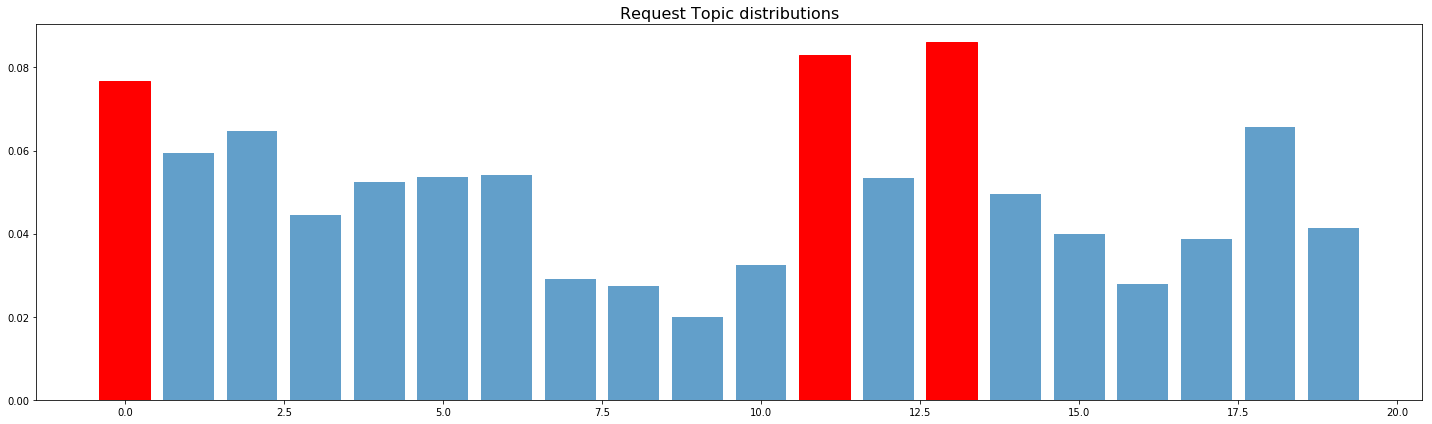

In [30]:
fig, ax1 = plt.subplots(1,1,figsize=(20,6))
nr_top_bars = 3
ax1.set_title("Request Topic distributions", fontsize=16)

for ax, distribution, color in zip([ax1], [RequestTopicDistribution], ['r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)

fig.tight_layout(h_pad=3.)

#### Inspect topics and words

In [31]:
def get_topic_and_prob(lda_model, topic_id, nr_top_words=7):
    id_tuples = lda_model.print_topic(topic_id, topn=nr_top_words)
    return id_tuples

In [32]:
for x in sorted(np.argsort(RequestTopicDistribution)[-num_topics:]):
    top_words = get_topic_and_prob(LDAmodel_scope, x, 5) #get_topic_top_words(LDAmodel, x)
    print("Topic: {0}\tProb: {1:.3f}, Words: {2}.".format(x, RequestTopicDistribution.item(x), top_words)) #(x, ", ".join(top_words)))
print("")

Topic: 0	Prob: 0.077, Words: 0.041*"feri" + 0.021*"hold" + 0.021*"dag" + 0.017*"feriedagpeng" + 0.014*"feriepeng".
Topic: 1	Prob: 0.059, Words: 0.027*"send" + 0.018*"mail" + 0.011*"du_har" + 0.010*"tak_for" + 0.009*"akademikernes_akas".
Topic: 2	Prob: 0.065, Words: 0.059*"vedhæft" + 0.042*"frigørelsestilest" + 0.029*"kontrak" + 0.029*"send" + 0.024*"ansættelseskontrak".
Topic: 3	Prob: 0.045, Words: 0.027*"modtag" + 0.022*"brev" + 0.015*"at_jeg" + 0.013*"dagpeng" + 0.011*"om_at".
Topic: 4	Prob: 0.053, Words: 0.038*"ansøgning" + 0.026*"forbind" + 0.025*"forbindelse_med" + 0.025*"i_forbind" + 0.024*"ansøgning_om".
Topic: 5	Prob: 0.054, Words: 0.017*"jeg_" + 0.015*"ansat" + 0.010*"at_jeg" + 0.009*"job" + 0.009*"start".
Topic: 6	Prob: 0.054, Words: 0.042*"meld" + 0.036*"led" + 0.017*"mig_led" + 0.016*"jobn" + 0.014*"jobcent".
Topic: 7	Prob: 0.029, Words: 0.034*"mul" + 0.015*"forlæng" + 0.014*"mulighed_for" + 0.014*"forsøg" + 0.013*"log".
Topic: 8	Prob: 0.027, Words: 0.017*"par" + 0.016*"et_

In [33]:
def get_lda_topics(model, num_topics, topn=10):
    word_dict = {};
    for i in sorted(np.argsort(RequestTopicDistribution)[-num_topics:]):
        words = model.show_topic(i, topn = topn);
        word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [34]:
get_lda_topics(LDAmodel_scope, num_topics,15)

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19
0,feri,send,vedhæft,modtag,ansøgning,jeg_,meld,mul,par,jul,forhånd,fejl,udfyld,at_d,ydelseskort,efterløn,suppl,jeg_,dagpeng,gern
1,hold,mail,frigørelsestilest,brev,forbind,ansat,led,forlæng,et_par,nytår,på_forhånd,at_jeg,blanket,til_at,tim,udbetaling,ansøgning,tvivl,er_d,jeg_vil
2,dag,du_har,kontrak,at_jeg,forbindelse_med,at_jeg,mig_led,mulighed_for,prøv,jul_og,forhånd_tak,fået,blank,arbejd,arbejd,tak_for,dagpeng,i_tvivl,arbejd,virksom
3,feriedagpeng,tak_for,send,dagpeng,i_forbind,job,jobn,forsøg,går,dagpeng,hjælp,jeg_ik,ak,at_jeg,måned,pension,supplerende_dagpeng,tvivl_om,job,arbejd
4,feriepeng,akademikernes_akas,ansættelseskontrak,om_at,ansøgning_om,start,jobcent,log,forsøg,og_nytår,tak_for,en_fejl,har_udfyld,det_,udfyld,går,brug,udfyld,forhold,år
5,optjent,brev,jeg_send,har_modtag,send,arbejd,at_jeg,kontak,lang,der_,for_hjælp,at_d,indsend,for_at,mit_ydelseskort,svar,ansøgning_om,er_i,jeg_,vil_g
6,afhold,ring,har_vedhæft,haft,fremsend,stilling,jeg_,for_at,tid,arbejdsplad,kan_i,dagpeng,ar,mul,period,gå,kontak,hjælp,jeg_skal,selvstænd
7,feriedag,for_din,kopi,arbejd,ansøg,ansæt,dag,jeg_kan,gang,kollektiv,jeg_kan,måned,ledighedserklæring,jeg_,løn,udbetalt,i_har,i_kan,skal_jeg,jeg_
8,udbetalt,vedhæft,vedkom,jeg_,befordringsgodtgør,da_jeg,melde_m,er_d,skriv,ferielukning,dagpeng,udbetalt,jeg_udfyld,der_,dagpeng,at_jeg,hvis_i,håb,hvis_jeg,vil_jeg
9,at_jeg,besked,rette_vedkom,ret,vedhæft,måned,på_jobn,muligt_at,find,mellem_jul,brug,der_,håb,håb,dag,jeg_vil,om_suppl,jeg_skal,søg,mul


#### Name the topics

In [192]:
lda_topic_names = {
    0:'Ferie og feriepenge',
    1:'Sendt oplysninger til AKA',
    2:'Ansættelseskontrakt eller frigørelse',
    3:'Spørgsmål om dagpenge',
    4:'Ansøgning om befordring',
    5:'Har fået job',
    6:'Meld ledig',
    8:'Noget med tid*',
    9:'Dagpenge mellem jul og nytår',
    11:'Fejl ved dagpenge',
    12:'Spørgsmål til blanket',
    14:'Ydelseskort',
    15:'Pension og Efterløn',
    16:'Supplerende dagpenge',
    19:'Spørgsmål om beskæftigelse'
}

### Test the model

In [193]:
pd.options.display.max_colwidth = 200

In [194]:
document = scope_lda_sample.sample(1)
doc_id = document['ThreadMessageID']
unseen_document = document['text']
print(doc_id, unseen_document)

963647    0B2DEE77-6947-E711-BE8E-005056AD2D14
Name: ThreadMessageID, dtype: object 963647    har forelæst fire timer på mph uddannelsen i public health i maj og skal undervise 6 timer 14. juni.\nman får løn for 2,5 timers forberedelsestid pr forelæsning.\njeg vedhæfter den dokumentation j...
Name: text, dtype: object


In [195]:
# Test function and prediction
print(lda_predict_string(unseen_document, LDAmodel_scope, dictionary,lda_topic_names))

(0.3476802, 'Ydelseskort', '0.036*"ydelseskort" + 0.034*"tim" + 0.021*"arbejd" + 0.015*"måned" + 0.013*"udfyld"')


In [ ]:
bow_vector = dictionary.doc2bow(lda_preprocess_string(unseen_document))
for index, score in sorted(LDAmodel_scope[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, LDAmodel_scope.print_topic(index, 5)))

# index, score = sorted(LDAmodel_scope[bow_vector], key=lambda tup: -1*tup[1])[0]
# print("Score: {}\t Topic: {}".format(score, LDAmodel_scope.print_topic(index, 5)))

### Predict topics on data
Per every row in the dataset

In [ ]:
def lda_prediction(df,lda_model, lda_topic_name_list):
    " Make the following function into a function that returns the pred_label and pred_prob below"
#     for index, score in sorted(LDAmodel_lang[bow_vector], key=lambda tup: -1*tup[1]):
#         print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
    
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    df['prediction'] = df['bow'].apply(PredictTopicFromBOW,lda_model=lda_model, lda_topic_name_list=lda_topic_name_list)
    df[['pred_probability','pred_index','pred_label']] = pd.DataFrame(df.prediction.values.tolist(), index= df.index)
    df.drop(['prediction'], axis=1)

In [ ]:
%%time
lda_predict_df(df_scope,LDAmodel_scope, dictionary, lda_topic_names)

#### Save the data with prediction

In [ ]:
df_scope.to_pickle('data/AKA_{0}_with_prediction.pkl'.format(data_scope))

### Load to MS SQL server

In [ ]:
%%time
df_raw = pd.read_pickle('data/AKA_rawdata.pkl')

In [ ]:
# from lipht_lda import df_lda_preprocessing

In [ ]:
%%time
df_lda_preprocessing(df_raw, 'ThreadMessageText')

In [ ]:
df_raw.columns

In [ ]:
df_raw.to_pickle('data/AKA_rawdata_df_lda_preprocessed.pkl')

In [ ]:
%%time
lda_prediction(df_raw,LDAmodel_scope, lda_topic_names)

In [ ]:
# df_raw[df_raw['pred_label']=='English']['text']

In [ ]:
df_raw_with_language = df_raw[['ThreadID','ThreadMessageID','ThreadMessageText','text','pred_label','pred_probability']]

In [ ]:
df_raw_with_language.head()

In [ ]:
df_raw_with_language.to_csv('lang_pred.csv')

In [ ]:
con = "mssql+pyodbc:///?odbc_connect={}".format(urllib.parse.quote_plus("DRIVER=ODBC Driver 13 for SQL Server;SERVER={0};PORT=1433;DATABASE={1};UID={2};PWD={3};TDS_Version=8.0;".format(server, db, user, password)))

In [ ]:
test = pd.DataFrame({'test':[1,2,3]}) #'te','te','te'

In [ ]:
import pyodbc
from sqlalchemy import create_engine
import urllib

params = urllib.parse.quote_plus(r'DRIVER={SQL Server};SERVER=LIPHT-VM-01;DATABASE=Akademikernes_MSCRM_addition;Trusted_Connection=yes')
conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(params)
engine = create_engine(conn_str)


test.to_sql(name='Test',con=engine , schema='input', if_exists='replace', index=False)

In [ ]:
df_raw.to_pickle('data/AKA_rawdata_with_language.pkl')

In [ ]:
df_raw.columns